In [77]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [78]:
#loading the data
train_data=pd.read_csv(r"C:\Users\Nehad\Downloads\train_s3TEQDk.csv")
test_data=pd.read_csv(r"C:\Users\Nehad\Downloads\test_mSzZ8RL.csv")

In [79]:
#inspecting the data size
print(train_data.shape)
print(test_data.shape)

(245725, 11)
(105312, 10)


### The train data has 245725 rows and 11 columns whereas test data has 105312 rows and 10 columns¶

In [80]:
# checking null values in train data
train_data.isnull().sum()/train_data.shape[0]*100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.934073
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64

In [81]:
#checking null values in test data
test_data.isnull().sum()/test_data.shape[0]*100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.890383
Avg_Account_Balance     0.000000
Is_Active               0.000000
dtype: float64

### In both train and test data,the credit product column has more than 11% missing values

In [82]:
#Since the credict product is a Categorical Column so we can fill the missing values with the help of mode function
train_data['Credit_Product'].fillna(train_data['Credit_Product'].mode()[0],inplace=True)
test_data['Credit_Product'].fillna(test_data['Credit_Product'].mode()[0],inplace=True)

In [83]:
print(train_data.isnull().sum())
print('--------')
print(test_data.isnull().sum())
#now the test and train data has no missing values

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64
--------
ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
dtype: int64


### Before fitting any model,First let us explore the data by performing Exploratory Data Analysis

In [84]:
train_data.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

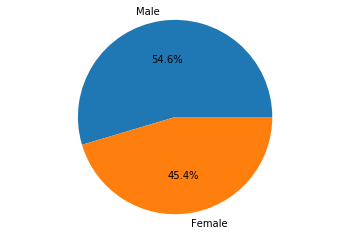

In [85]:
# Seeing the proportion of Male and Female customers
gender_value=train_data['Gender'].value_counts().index
gender_count=train_data['Gender'].value_counts().values
plt.pie(gender_count,labels=gender_value,autopct='%.1f%%')
plt.axis('equal')
plt.show()

### Bank has larger proportion of male customers than female(difference being almost 5%)

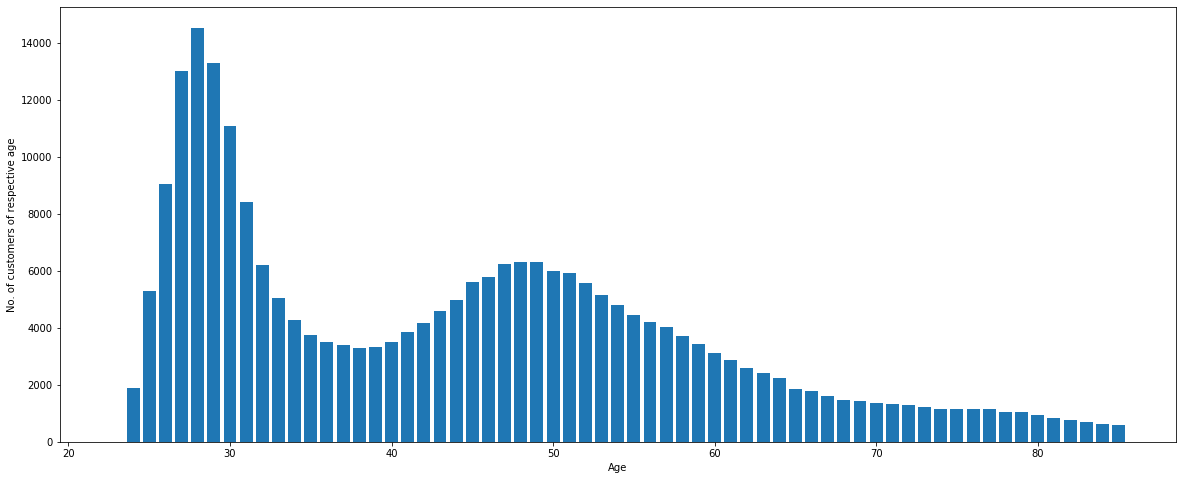

In [86]:
# Exploring the age range of customers and seeing the relationship between age and the interest in buying credit cards
plt.figure(figsize=(20,8))
age_value=train_data["Age"].value_counts().index
age_count=train_data["Age"].value_counts().values
plt.bar(age_value,age_count)
plt.xlabel('Age')
plt.ylabel("No. of customers of respective age")
plt.show()

### 1)The age range of customers of Bank is from 22 to 85 years
### 2)The bank has maximum number of customers of age 26-28 years
### 3)The bank should target young customers as the risk factor(in investment) decreases with age

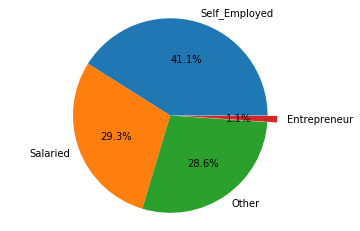

In [87]:
# Visualizing the proportion of people with different occupation
Occupation_value=train_data['Occupation'].value_counts().index
Occupation_count=train_data['Occupation'].value_counts().values
plt.pie(Occupation_count,labels=Occupation_value,autopct='%.1f%%',explode=[0,0,0,0.1])
plt.axis('equal')
plt.show()

### Majority of customers are either self_employed or are salaried.Very few(only 1%) are enterpreneur

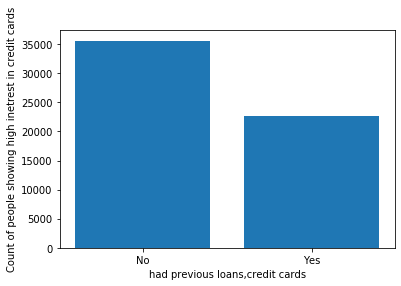

In [88]:
# Interpreting the behaviour of customers who already have loans,credit cards 
Yes_credit=train_data[train_data['Is_Lead']==1]
Credit_Product=Yes_credit['Credit_Product'].value_counts().index
Credit_Product_count=Yes_credit['Credit_Product'].value_counts().values
plt.bar(Credit_Product,Credit_Product_count)
plt.xlabel("had previous loans,credit cards")
plt.ylabel("Count of people showing high inetrest in credit cards")
plt.show()

### The customers who do not have any credit_product tend to show higher interest in recommended credit cards

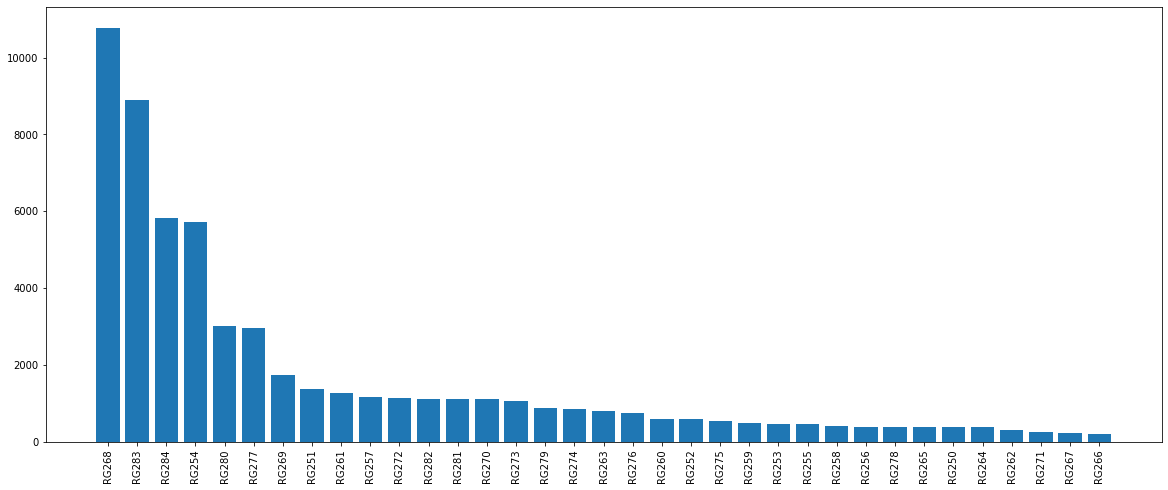

In [89]:
# Seeing if region is impacting the behaviour of customers or not that is if the interest of customers is in anyway dependent upon the region in which they live
plt.figure(figsize=(20,8))
Yes_credit=train_data[train_data['Is_Lead']==1]
region_code=Yes_credit['Region_Code'].value_counts().index
region_code_count=Yes_credit['Region_Code'].value_counts().values
plt.bar(region_code,region_code_count)
plt.xticks(rotation=90)
plt.show()

### The region_code is playing a crucial role in deciding whether the customer is interested in buying recomemended credit cards.The customers having region code RG268 shows a very high interest in buying credit cards

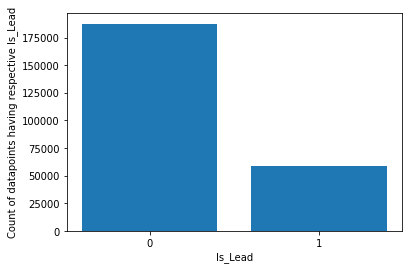

In [90]:
#Checking if the training data is balanced or not(This is important because it will have a large impact on the metric which we will use further for checking the accuracy of model)
rows_of_lead_1=train_data[train_data['Is_Lead']==1].shape[0]
rows_of_lead_0=train_data[train_data['Is_Lead']==0].shape[0]
plt.bar([1,0],[rows_of_lead_1,rows_of_lead_0])
plt.xticks([1,0])
plt.xlabel('Is_Lead')
plt.ylabel('Count of datapoints having respective Is_Lead')
plt.show()

### The above bargraph clearly shows that the train data is highly imbalanced

In [91]:
# Our goal now will be to first make our data balanced
train_data=pd.concat([train_data[train_data['Is_Lead']==0].iloc[:60000,:],train_data[train_data['Is_Lead']==1]])
train_data

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...,...
245697,DTQJBXK6,Male,43,RG257,Salaried,X1,50,No,551203,Yes,1
245699,MARTXU7T,Male,53,RG254,Other,X2,19,No,1141825,Yes,1
245709,4GZKAUQC,Male,36,RG284,Self_Employed,X3,15,Yes,608110,Yes,1
245713,BZ7NHPMJ,Female,41,RG277,Self_Employed,X2,13,Yes,898170,Yes,1


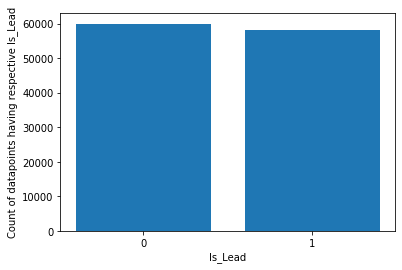

In [92]:
rows_of_lead_1=train_data[train_data['Is_Lead']==1].shape[0]
rows_of_lead_0=train_data[train_data['Is_Lead']==0].shape[0]
plt.bar([1,0],[rows_of_lead_1,rows_of_lead_0])
plt.xticks([1,0])
plt.xlabel('Is_Lead')
plt.ylabel('Count of datapoints having respective Is_Lead')
plt.show()

### The train_data has become balanced now

In [93]:
# Now Preparing the proper input dataset, compatible with the machine learning algorithm requirements
train_data.drop('ID',axis=1,inplace=True)

In [94]:
test_data.drop('ID',axis=1,inplace=True)

In [95]:
# Encoding the features of training data(using label encoding )
label = preprocessing.LabelEncoder()
for column_name in train_data.columns:
    if train_data[column_name].dtype==object:
       
        train_data[column_name] = label.fit_transform(train_data[column_name])


# Encoding the features of testing data
label = preprocessing.LabelEncoder()
for column_name in test_data.columns:
    if test_data[column_name].dtype==object:
       
   
        test_data[column_name] = label.fit_transform(test_data[column_name])

In [96]:
train_data.dtypes

Gender                 int32
Age                    int64
Region_Code            int32
Occupation             int32
Channel_Code           int32
Vintage                int64
Credit_Product         int32
Avg_Account_Balance    int64
Is_Active              int32
Is_Lead                int64
dtype: object

In [97]:
test_data.dtypes

Gender                 int32
Age                    int64
Region_Code            int32
Occupation             int32
Channel_Code           int32
Vintage                int64
Credit_Product         int32
Avg_Account_Balance    int64
Is_Active              int32
dtype: object

In [98]:
# differentiating the attributes from the target(for training data)
dummy_train_values=train_data.values
dummy_train_attributes=dummy_train_values[:,:-1]
dummy_train_target=dummy_train_values[:,-1]

In [99]:
dummy_test_values=test_data.values

In [100]:
# Now doing feature scaling because we can see that Avg_account_balance column is not in range with the other columns
Scaler=StandardScaler()
Scaler.fit(dummy_train_attributes)
dummy_train_attributes=Scaler.transform(dummy_train_attributes) # for train data
dummy_test_values=Scaler.transform(dummy_test_values) # for test data

In [101]:
# Since we are done with all the preprocessing on the data-now we will train the model
# Before training let us first split the train data into training and testing data
X_train,X_test,Y_train,Y_test=model_selection.train_test_split(dummy_train_attributes,dummy_train_target,random_state=1,test_size=0.2)

### Logistic Regression

In [102]:
# Finally fitting the model
clf=LogisticRegression()
clf.fit(X_train,Y_train)


C:\Users\Nehad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [103]:
Y_test_prediction=clf.predict(X_test)
Y_test_prediction

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [104]:
# checking the accuracy
print(classification_report(Y_test,Y_test_prediction))
logistic_score=clf.score(X_test,Y_test)
print(logistic_score)

              precision    recall  f1-score   support

           0       0.67      0.64      0.66     12048
           1       0.65      0.67      0.66     11610

    accuracy                           0.66     23658
   macro avg       0.66      0.66      0.66     23658
weighted avg       0.66      0.66      0.66     23658

0.6581705976836588


### Naive Bayes 

In [105]:
gnb=GaussianNB()

In [106]:
gnb.fit(X_train,Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [107]:
prediction_Gaussian=gnb.predict(X_test)
prediction_Gaussian

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [108]:
# checking the accuracy
print(classification_report(Y_test,prediction_Gaussian))
gaussian_score=gnb.score(X_test,Y_test)
print(gaussian_score)

              precision    recall  f1-score   support

           0       0.68      0.62      0.65     12048
           1       0.64      0.70      0.67     11610

    accuracy                           0.66     23658
   macro avg       0.66      0.66      0.66     23658
weighted avg       0.66      0.66      0.66     23658

0.6590582466818835


### Decision Tree

In [109]:
tree=DecisionTreeClassifier()

In [110]:
tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [111]:
tree_prediction=tree.predict(X_test)
tree_prediction

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [112]:
# checking the accuracy
print(classification_report(Y_test,tree_prediction))
tree_score=tree.score(X_test,Y_test)
print(tree_score)

              precision    recall  f1-score   support

           0       0.63      0.63      0.63     12048
           1       0.61      0.61      0.61     11610

    accuracy                           0.62     23658
   macro avg       0.62      0.62      0.62     23658
weighted avg       0.62      0.62      0.62     23658

0.6218615267562769


### Random Forest

In [113]:
random_forest=RandomForestClassifier()

In [114]:
random_forest.fit(X_train,Y_train)

C:\Users\Nehad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [115]:
random_prediction=random_forest.predict(X_test)
random_prediction

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [116]:
# checking the accuracy
print(classification_report(Y_test,random_prediction))
random_score=random_forest.score(X_test,Y_test)
print(random_score)

              precision    recall  f1-score   support

           0       0.66      0.73      0.69     12048
           1       0.68      0.62      0.65     11610

    accuracy                           0.67     23658
   macro avg       0.67      0.67      0.67     23658
weighted avg       0.67      0.67      0.67     23658

0.6721616366556767


### XBoost

In [117]:
xgb=XGBClassifier(max_depth=3,n_estimators=300,learning_rate=0.05).fit(X_train,Y_train)

C:\Users\Nehad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [118]:
xgb_prediction=xgb.predict(X_test)
xgb_prediction

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

In [119]:
# checking the accuracy
print(classification_report(Y_test,xgb_prediction))
xgb_score=xgb.score(X_test,Y_test)
print(xgb_score)

              precision    recall  f1-score   support

           0       0.74      0.70      0.72     12048
           1       0.70      0.74      0.72     11610

    accuracy                           0.72     23658
   macro avg       0.72      0.72      0.72     23658
weighted avg       0.72      0.72      0.72     23658

0.7181925775636149


### GradientBoostClassifier

In [120]:
gradient_boost_clf = GradientBoostingClassifier()
gradient_boost_clf.fit(X_train, Y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [121]:
gradient_boost_prediction=gradient_boost_clf.predict(X_test)
gradient_boost_prediction

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

In [122]:
# checking the accuracy
print(classification_report(Y_test,gradient_boost_prediction))
gradient_boost_score=gradient_boost_clf.score(X_test,Y_test)
print(gradient_boost_score)

              precision    recall  f1-score   support

           0       0.74      0.70      0.72     12048
           1       0.70      0.74      0.72     11610

    accuracy                           0.72     23658
   macro avg       0.72      0.72      0.72     23658
weighted avg       0.72      0.72      0.72     23658

0.7180657705638684


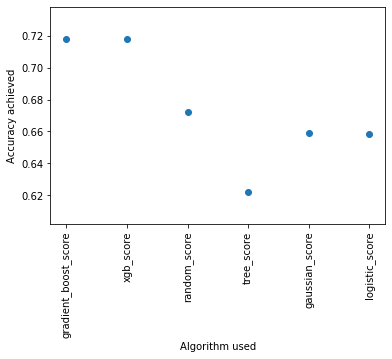

In [133]:
# Let us compare the accuracy obtained from various models and compare them to decide which one to use 
algo=['gradient_boost_score','xgb_score','random_score','tree_score','gaussian_score','logistic_score']
models_accuracy=[gradient_boost_score,xgb_score,random_score,tree_score,gaussian_score,logistic_score]
plt.scatter(algo,models_accuracy,marker='o')
plt.xticks(rotation=90)
plt.xlabel('Algorithm used')
plt.ylabel('Accuracy achieved')
plt.show()

### It is clearly visible that XGBoost classifier gives the highest accuracy so i will be choosing this algorithm to predict on the test data

In [134]:
# Prediction from the model
submission=pd.read_csv(r"C:\Users\Nehad\OneDrive\Documents\submission_by_me.csv")
xgb_predictions=xgb.predict(dummy_test_values)
submission["Is_Lead"]=xgb_predictions
submission.to_csv("submission_for_hacakthon_xgb.csv",index=False)